## Data Preparation and Preprocessing

The dataset consists of information about the purchasing behavior of 2,000 individuals from a given area when entering a physical ‘FMCG’ store. All data has been collected through the loyalty cards they use at checkout. The data has been preprocessed and there are no missing values. In addition, the volume of the dataset has been restricted and anonymised to protect the privacy of the customers. 


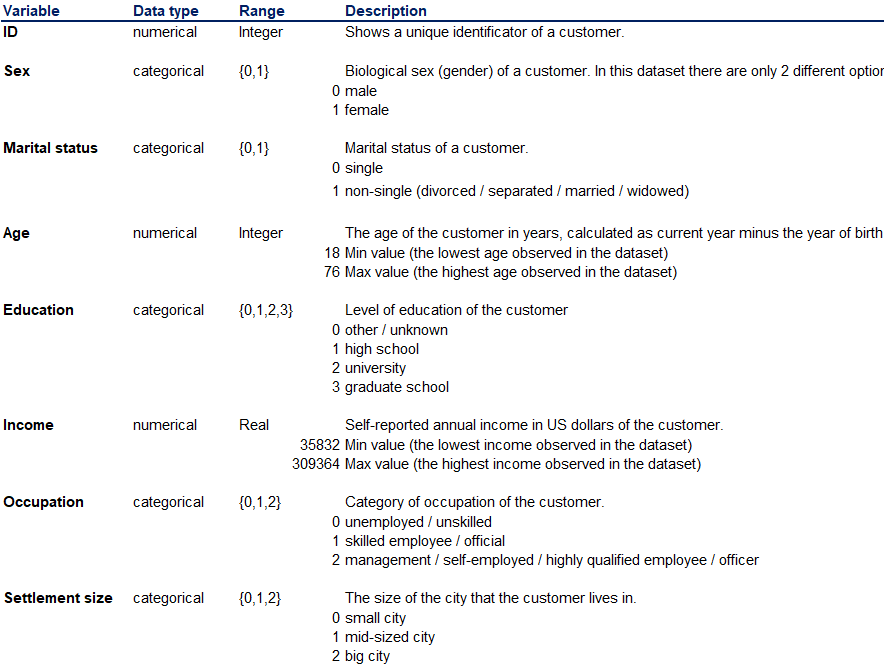

### Strategy:

I plan to use K-Means Clustering in order to help me determine the various clusters prevalent in the customer dataset. Seeing as  many of the explanatory variables listed above are categorical, I will have to make sure that these are appropriately represented - i.e. that they are correctly transformed into factors if they are already not so. I will perform Exploratory Data Analysis to get a better sense of the data provided but I will also use it to determine if the data will need to be scaled before performing Clustering. Perhaps the most effective way of doing this will be to perform clustering on the scaled and unscaled dataset and to compare the results given.

To help me determine the suitable amount of clusters to be generated, I will be using the Elbow Method and should this not prove appropriate then I shall use the Silhouette Method. The Elbow Method is not always appropriate and the results can sometimes be ambivalent. The Silhouette Method on the other hand is more appropriate and a silhouette statistic is less vague to understand (Strong positive scores designate that the data points fit well in their assigned clusters.)

### Part 1: Data Preparation

In [1]:
library(dplyr)
library(ggplot2)
library(gridExtra)
library(tidyr)
library(cluster)
library(caret)
library(reshape2)
library(corrplot)
library(randomForest)
library(lmtest)
library(zoo)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine


Loading required package: lattice


Attaching package: 'reshape2'


The following object is masked from 'package:tidyr':

    smiths


corrplot 0.92 loaded

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:gridExtra':

    combine


The following object is masked from 'package:ggplot2':

    margin


The following object is masked from 'package:dplyr':

    combine


Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric




In [2]:
customData <- read.csv("data/segmentation_data.csv")

In [3]:
str(customData)

'data.frame':	2000 obs. of  8 variables:
 $ ID             : int  100000001 100000002 100000003 100000004 100000005 100000006 100000007 100000008 100000009 100000010 ...
 $ Sex            : int  0 1 0 0 0 0 0 0 0 0 ...
 $ Marital.status : int  0 1 0 0 0 0 0 0 1 1 ...
 $ Age            : int  67 22 49 45 53 35 53 35 61 28 ...
 $ Education      : int  2 1 1 1 1 1 1 1 2 1 ...
 $ Income         : int  124670 150773 89210 171565 149031 144848 156495 193621 151591 174646 ...
 $ Occupation     : int  1 1 0 1 1 0 1 2 0 2 ...
 $ Settlement.size: int  2 2 0 1 1 0 1 1 0 0 ...


In [4]:
# Checking to see if the data set loaded correctly
head(customData, 10)

,ID,Sex,Marital.status,Age,Education,Income,Occupation,Settlement.size
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,100000001,0,0,67,2,124670,1,2
2,100000002,1,1,22,1,150773,1,2
3,100000003,0,0,49,1,89210,0,0
4,100000004,0,0,45,1,171565,1,1
5,100000005,0,0,53,1,149031,1,1
6,100000006,0,0,35,1,144848,0,0
7,100000007,0,0,53,1,156495,1,1
8,100000008,0,0,35,1,193621,2,1
9,100000009,0,1,61,2,151591,0,0


The ID column will be removed as it can be determined that this will not be necessary to conduct K Means Clustering. 

In [5]:
customData <- subset(customData, select = -ID)

### Part 2: Exploratory Data Analysis

In [6]:
summary(customData)

      Sex        Marital.status        Age          Education    
 Min.   :0.000   Min.   :0.0000   Min.   :18.00   Min.   :0.000  
 1st Qu.:0.000   1st Qu.:0.0000   1st Qu.:27.00   1st Qu.:1.000  
 Median :0.000   Median :0.0000   Median :33.00   Median :1.000  
 Mean   :0.457   Mean   :0.4965   Mean   :35.91   Mean   :1.038  
 3rd Qu.:1.000   3rd Qu.:1.0000   3rd Qu.:42.00   3rd Qu.:1.000  
 Max.   :1.000   Max.   :1.0000   Max.   :76.00   Max.   :3.000  
     Income         Occupation     Settlement.size
 Min.   : 35832   Min.   :0.0000   Min.   :0.000  
 1st Qu.: 97663   1st Qu.:0.0000   1st Qu.:0.000  
 Median :115549   Median :1.0000   Median :1.000  
 Mean   :120954   Mean   :0.8105   Mean   :0.739  
 3rd Qu.:138072   3rd Qu.:1.0000   3rd Qu.:1.000  
 Max.   :309364   Max.   :2.0000   Max.   :2.000  

My initial thoughts on this dataset are the many categorical variables present. 5 from 7 columns are categorical which means if any scaling is required then appropriate action must be taken. Going by the numerical variables alone, I would suspect that these would need to be scaled, as the Income values are way greater than the age values which means it also carries more weight.

I will go ahead and a make a new dataframe where the categorical variables all have the appropriate data type, i.e. Factors with appropriate levels. This will also assist in conducting Exploratory Data Analysis. 

In [7]:
# Factors will be included in this temporary dataframe to assist with EDA
customDataWithFactors <- customData %>%
    mutate(Sex = factor(Sex),
          Marital.status = factor(Marital.status),
          Education = factor(Education),
          Occupation = factor(Occupation),
          Settlement.size = factor(Settlement.size))

In [8]:
summary(customDataWithFactors)

 Sex      Marital.status      Age        Education     Income       Occupation
 0:1086   0:1007         Min.   :18.00   0: 287    Min.   : 35832   0: 633    
 1: 914   1: 993         1st Qu.:27.00   1:1386    1st Qu.: 97663   1:1113    
                         Median :33.00   2: 291    Median :115549   2: 254    
                         Mean   :35.91   3:  36    Mean   :120954             
                         3rd Qu.:42.00             3rd Qu.:138072             
                         Max.   :76.00             Max.   :309364             
 Settlement.size
 0:989          
 1:544          
 2:467          
                
                
                

It is now possible to make effective of the descriptive statistics provided above. In terms of *Sex* and *Marital Status*, the data here is fairly balanced and both levels for both factors are represented. There is a rather diverse *Age* Range as well with our Median Age being 33.

The majority of the customers seem to have a high school diploma which means not all levels are represented, however, this can be assumed to be expected as it is a demographic feature that most members of the population will have attained a high school diploma. The range of *Income* is also very wide. 

Generally, the dataset is arguably strong in representing many different types of customers. 

In [9]:
attach(customDataWithFactors)

In [10]:
plot1 <- ggplot(customDataWithFactors, aes(x = Sex)) + geom_bar()
plot2 <- ggplot(customDataWithFactors, aes(x = Marital.status)) + geom_bar()
plot3 <- ggplot(customDataWithFactors, aes(x = Education)) + geom_bar()
plot4 <- ggplot(customDataWithFactors, aes(x = Age)) + geom_bar()
plot5 <- ggplot(customDataWithFactors, aes(x = Income)) + geom_bar()
plot6 <- ggplot(customDataWithFactors, aes(x = Settlement.size)) + geom_bar()
plot7 <- ggplot(customDataWithFactors, aes(x = Occupation)) + geom_bar()

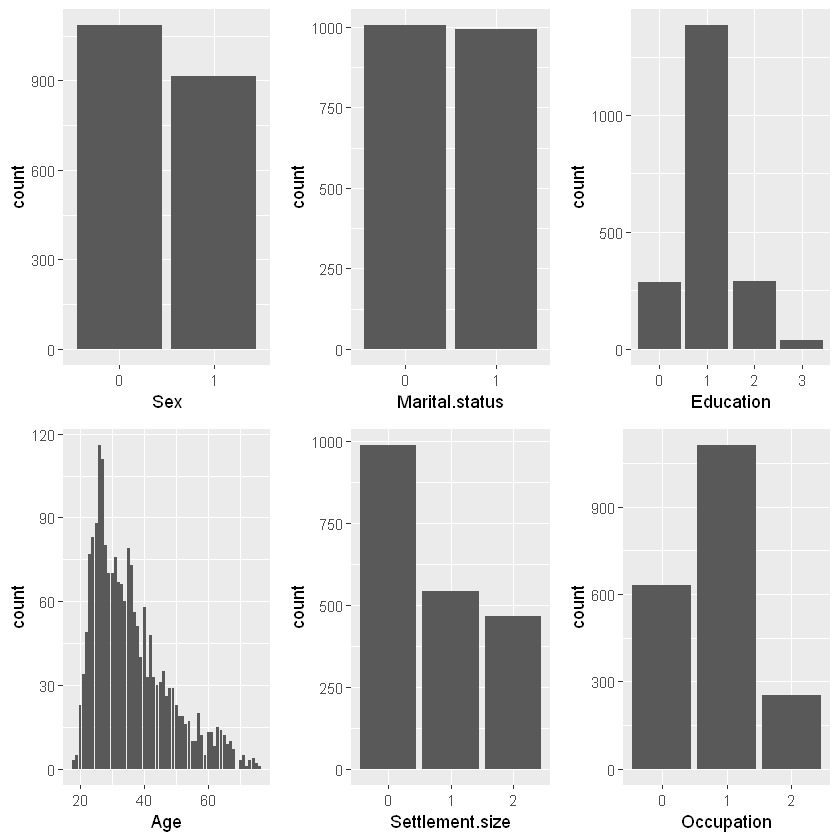

In [11]:
grid.arrange(plot1, plot2, plot3, plot4, plot6, plot7, ncol=3)

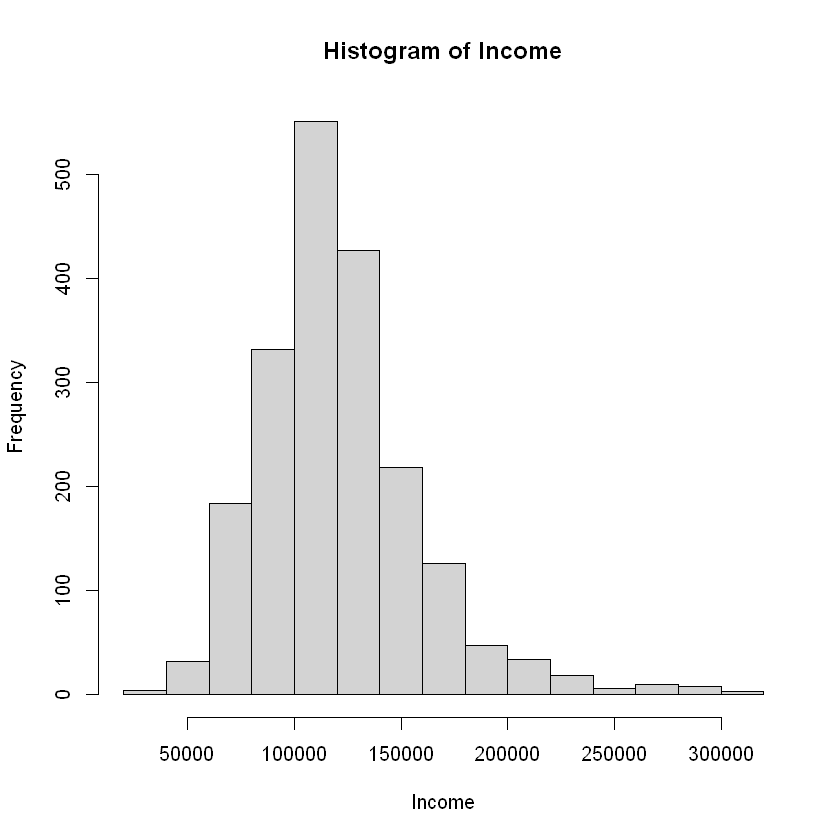

In [12]:
hist(Income)

In [13]:
mean(Income)

[1] 120954.4

The distribution of Income is slight right skewed, meaning that high income earners are represented less in the dataset. However, this might very well be unavoidable as there are generally less high income earners in the population.

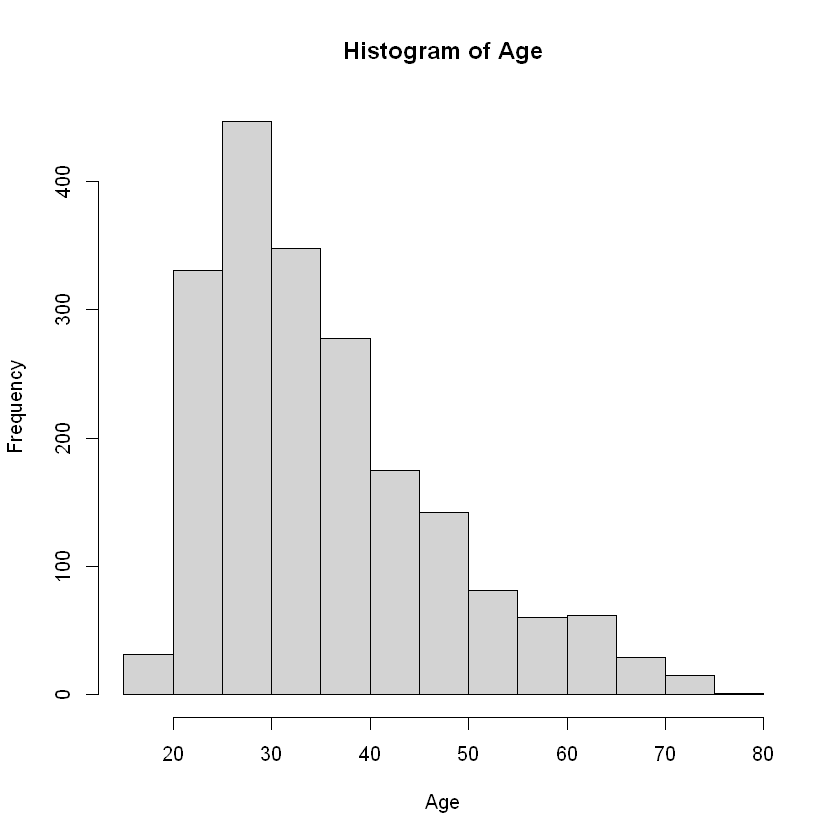

In [14]:
hist(Age)

In [15]:
mean(Age)

[1] 35.909

Although the min and max values of age would have us believe that many different ages are represented it is clear to see from the histogram produced above that the distribution of Age is strongly right skewed. This means contextually that older customers are not represented well. 

### Part 3: Scaling the Dataset

Before the data can be scaled in order to use k-means clustering, the data must first be transformed so that the categorical variables are made into dummy variables. This means essentially that we are creating binary indicator variables that represent the presence or absence of a particular categorical level. 

In [16]:
numeric_cols <- c("Age", "Income")

In [17]:
customDataNumScaled <- scale(customDataWithFactors[, c("Age", "Income")])

In [18]:
head(customDataNumScaled, 10)

,Age,Income
1,2.65295099,0.09749923
2,-1.18683527,0.78245869
3,1.11703649,-0.83299391
4,0.77572215,1.32805410
5,1.45835082,0.73674749
6,-0.07756368,0.62698289
7,1.45835082,0.93260764
8,-0.07756368,1.90681769
9,2.14097949,0.80392353
10,-0.67486377,1.40890152


In [19]:
cat_cols <- c("Education", "Settlement.size", "Sex", "Marital.status", "Occupation")

In [20]:
# Create dummy variables for the categorical columns
dummy_data <- predict(dummyVars("~ .", data = customDataWithFactors[, cat_cols]), newdata = customDataWithFactors[, cat_cols])

In [21]:
# Combine the numeric and dummy variables into one data frame
customDataScaled <- cbind(customDataNumScaled, dummy_data)

In [22]:
head(customDataScaled)

,Age,Income,Education.0,Education.1,Education.2,Education.3,Settlement.size.0,Settlement.size.1,Settlement.size.2,Sex.0,Sex.1,Marital.status.0,Marital.status.1,Occupation.0,Occupation.1,Occupation.2
1,2.65295099,0.09749923,0,0,1,0,0,0,1,1,0,1,0,0,1,0
2,-1.18683527,0.78245869,0,1,0,0,0,0,1,0,1,0,1,0,1,0
3,1.11703649,-0.83299391,0,1,0,0,1,0,0,1,0,1,0,1,0,0
4,0.77572215,1.32805410,0,1,0,0,0,1,0,1,0,1,0,0,1,0
5,1.45835082,0.73674749,0,1,0,0,0,1,0,1,0,1,0,0,1,0
6,-0.07756368,0.62698289,0,1,0,0,1,0,0,1,0,1,0,1,0,0


In [23]:
# Check the mean and standard deviation of the scaled data
apply(customDataScaled, 2, mean) # should be close to 0
apply(customDataScaled, 2, sd)  # should be close to 1

Age            Income       Education.0       Education.1 
     9.899048e-17      1.491409e-16      1.435000e-01      6.930000e-01 
      Education.2       Education.3 Settlement.size.0 Settlement.size.1 
     1.455000e-01      1.800000e-02      4.945000e-01      2.720000e-01 
Settlement.size.2             Sex.0             Sex.1  Marital.status.0 
     2.335000e-01      5.430000e-01      4.570000e-01      5.035000e-01 
 Marital.status.1      Occupation.0      Occupation.1      Occupation.2 
     4.965000e-01      3.165000e-01      5.565000e-01      1.270000e-01

Age            Income       Education.0       Education.1 
        1.0000000         1.0000000         0.3506697         0.4613647 
      Education.2       Education.3 Settlement.size.0 Settlement.size.1 
        0.3526924         0.1329844         0.5000948         0.4451012 
Settlement.size.2             Sex.0             Sex.1  Marital.status.0 
        0.4231634         0.4982722         0.4982722         0.5001128 
 Marital.status.1      Occupation.0      Occupation.1      Occupation.2 
        0.5001128         0.4652268         0.4969217         0.3330562

In [24]:
customDataScaled <- as.data.frame(customDataScaled)

### Part 4 A : K Means Clustering (Unscaled Data)

#### Using the Elbow Method

Testing from a range from 1 - 15, k-means clustering will be performed for each value of k and the within-cluster sum of squares (WCSS), which is the sum of the squared distances between each data point and its assigned centroid. The WCSS for each value of k will then be plotted. Looking for the *elbow* in the plot will assist in determining the optimal k value as this is where the decrease in WCSS begins to level off.

In [25]:
# Calculating the WCSS for all values of k
WCSS <- c()
for (i in 1:15) {
    kmeans_fit <- kmeans(customData, centers = i, nstart= 50)
    WCSS[i] <- kmeans_fit$tot.withinss
}

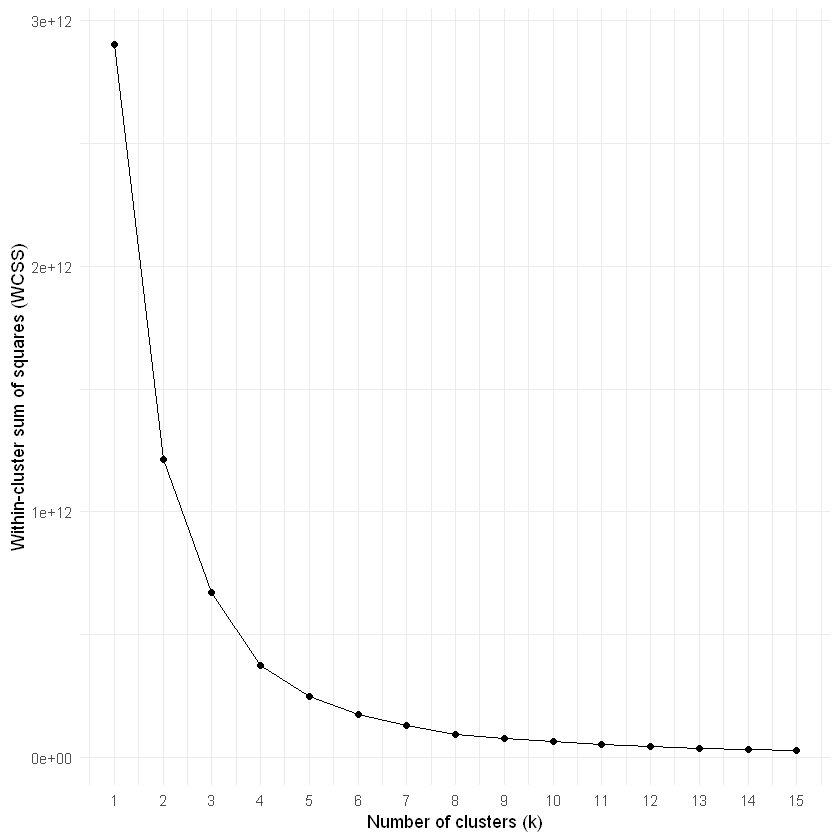

In [26]:
# Plotting the WCSS against the number of clusters
WCSS_df <- data.frame(k = 1:15, WCSS = WCSS)
ggplot(WCSS_df, aes(x = k, y = WCSS)) +
    geom_line() +
    geom_point() +
    scale_x_continuous(breaks = 1:15) +
    labs(x = 'Number of clusters (k)', y = 'Within-cluster sum of squares (WCSS)') +
    theme_minimal()

It is difficult to determine with the Elbow method used above, however, 6 clusters seem to be where the *elbow* occurs.

#### Using the Silhouette Method

Seeing as the results produced from using the Elbow Method above are unclear, we can try to use the Silhouette method. Just like in the elbow method, we will use the range 1 - 15 and for each value of k, k-means clustering will be performed. For each series of clustering per value of k produced, its corresponding Silhouette coefficient will be estimated; This is measured with coefficient ranges -1 to 1 measuring how well each data point belongs to its newly assigned cluster in comparison to other nearby clusters. Values closer to 1 indicate a good cluster assignment and values closer to -1 indicate a poor cluster assignment. We can then calculate the average Silhouette Coefficient for each series of clustering for each value of k. The results can be plotted and compared.

In [74]:
library(factoextra)

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



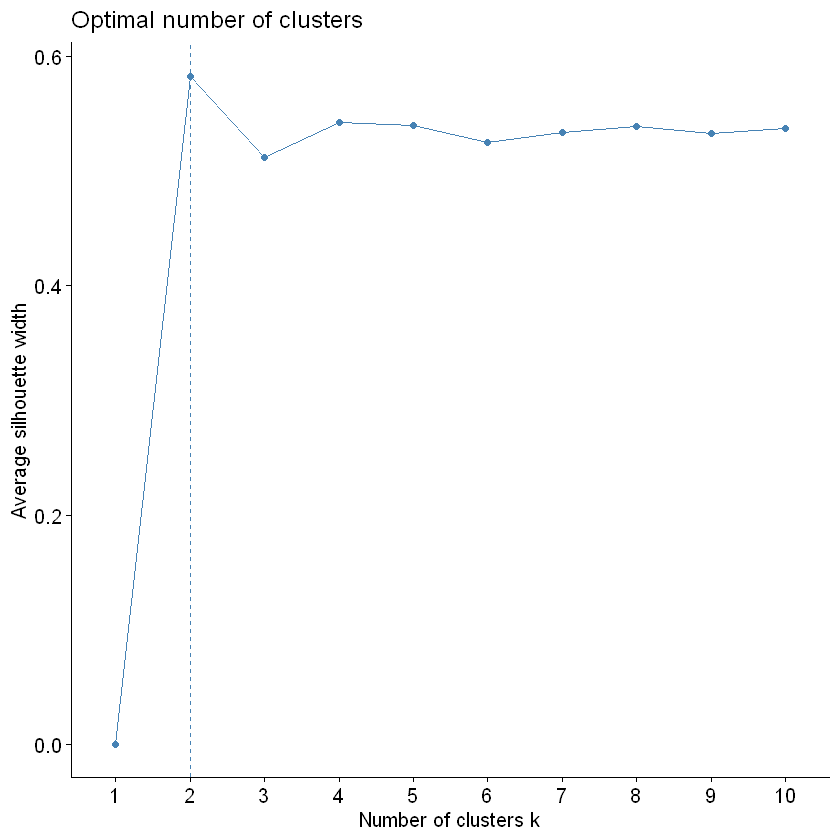

In [77]:
fviz_nbclust(customData, kmeans, method='silhouette')

### Part 4 B : K Means Clustering (Scaled Data)

#### Using the Elbow Method

In [29]:
# Calculating the WCSS for all values of k
WCSS <- c()
for (i in 1:15) {
    kmeans_fit <- kmeans(customDataScaled, centers = i, nstart= 50)
    WCSS[i] <- kmeans_fit$tot.withinss
}

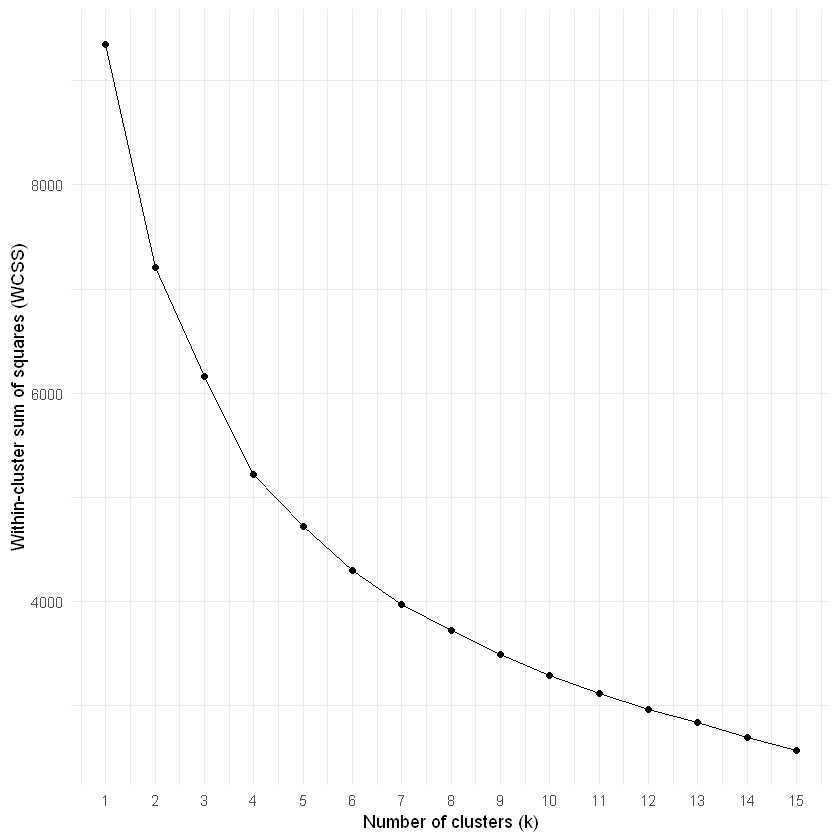

In [30]:
# Plotting the WCSS against the number of clusters
WCSS_df <- data.frame(k = 1:15, WCSS = WCSS)
ggplot(WCSS_df, aes(x = k, y = WCSS)) +
    geom_line() +
    geom_point() +
    scale_x_continuous(breaks = 1:15) +
    labs(x = 'Number of clusters (k)', y = 'Within-cluster sum of squares (WCSS)') +
    theme_minimal()

#### Using the Silhouette Method

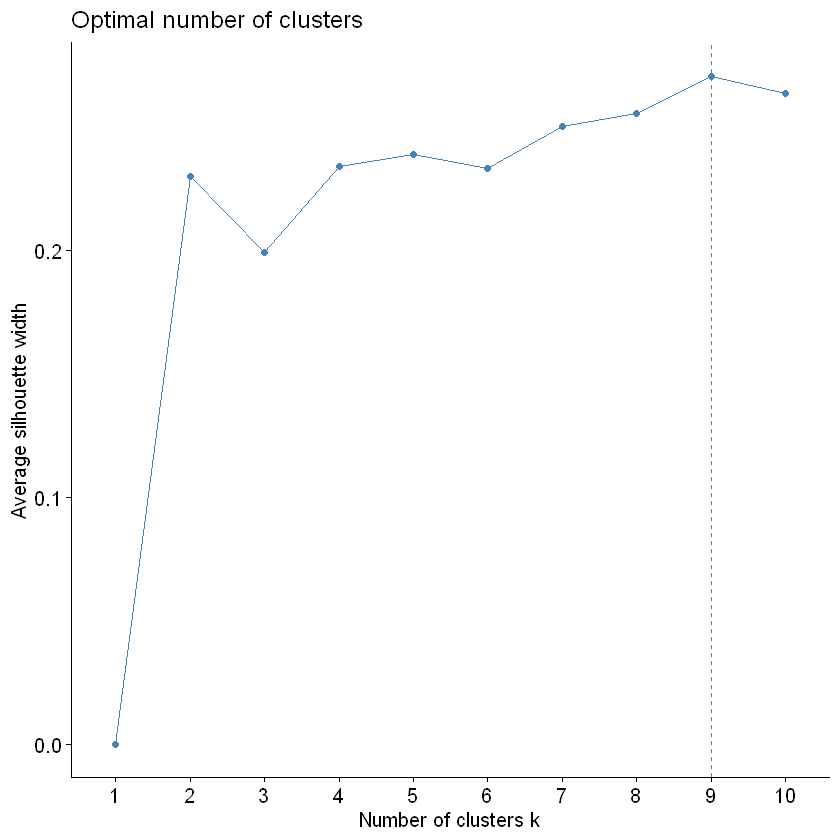

In [78]:
fviz_nbclust(customDataScaled, kmeans, method='silhouette')

It would seem that the data and the way it has been provided is not expected to be scaled before applying clustering. The Silhouette Method would have me believe, that the two cluster solution is perhaps the best solution, however, using the Elbow Method makes me believe that a 3 or 4 cluster solution is also possible. It might be worth checking these out if the two cluster solution does not seem adequate enough.

#### K Means Clustering and Analysis (Two Cluster Solution)

In [97]:
k <- kmeans(customData, 2)

In [98]:
bcss <- k$betweenss
bcss

[1] 1.688547e+12

In [80]:
k$centers

,Sex,Marital.status,Age,Education,Income,Occupation,Settlement.size
1,0.5131137,0.5191661,34.01681,0.9798252,103887.9,0.6139879,0.5494284
2,0.2943470,0.4307992,41.39376,1.2066277,170424.0,1.3801170,1.2884990


In [81]:
table(k$cluster)


   1    2 
1487  513 

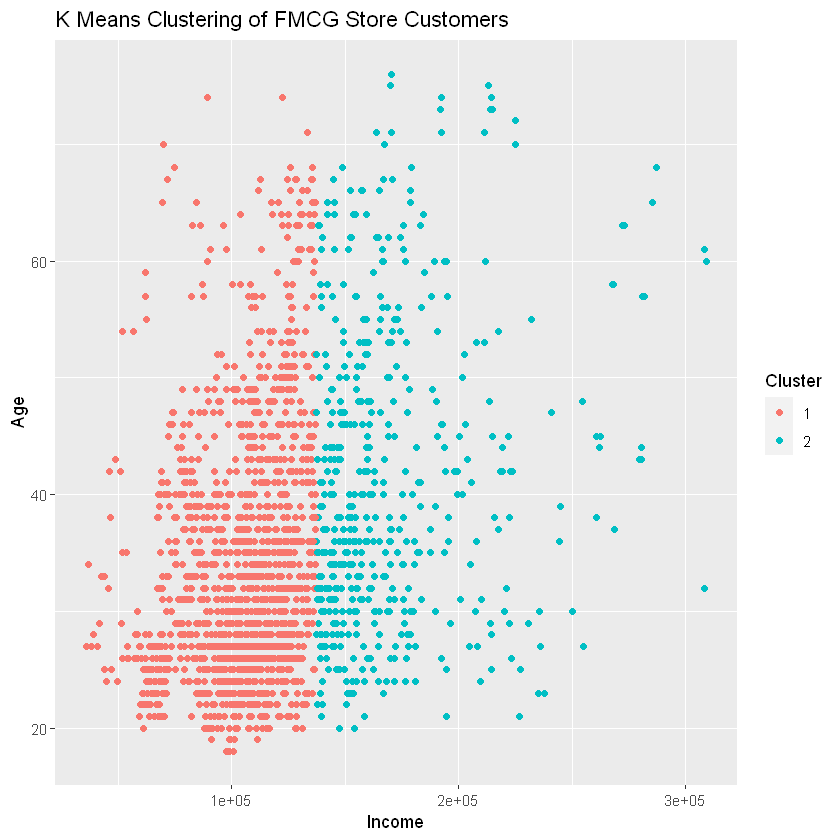

In [82]:
library(ggplot2)
ggplot(customData, aes(x = Income, y = Age, color = factor(k$cluster))) +
  geom_point() +
  labs(title = "K Means Clustering of FMCG Store Customers",
       x = "Income",
       y = "Age",
       color = "Cluster")

In [83]:
aggregate(customData, by = list(k$cluster), mean)

Group.1,Sex,Marital.status,Age,Education,Income,Occupation,Settlement.size
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.5131137,0.5191661,34.01681,0.9798252,103887.9,0.6139879,0.5494284
2,0.2943470,0.4307992,41.39376,1.2066277,170424.0,1.3801170,1.2884990


#### K Means Clustering and Analysis (Three Cluster Solution)

In [95]:
k <- kmeans(customData, 3)

In [96]:
bcss <- k$betweenss
bcss

[1] 2.23008e+12

In [85]:
k$centers

,Sex,Marital.status,Age,Education,Income,Occupation,Settlement.size
1,0.3859844,0.4471635,37.78532,1.072303,131420.04,0.9911012,0.9499444
2,0.2933333,0.4577778,43.87556,1.346667,197576.12,1.5777778,1.3644444
3,0.5719178,0.5570776,31.93721,0.923516,90533.78,0.4280822,0.3618721


In [86]:
table(k$cluster)


  1   2   3 
899 225 876 

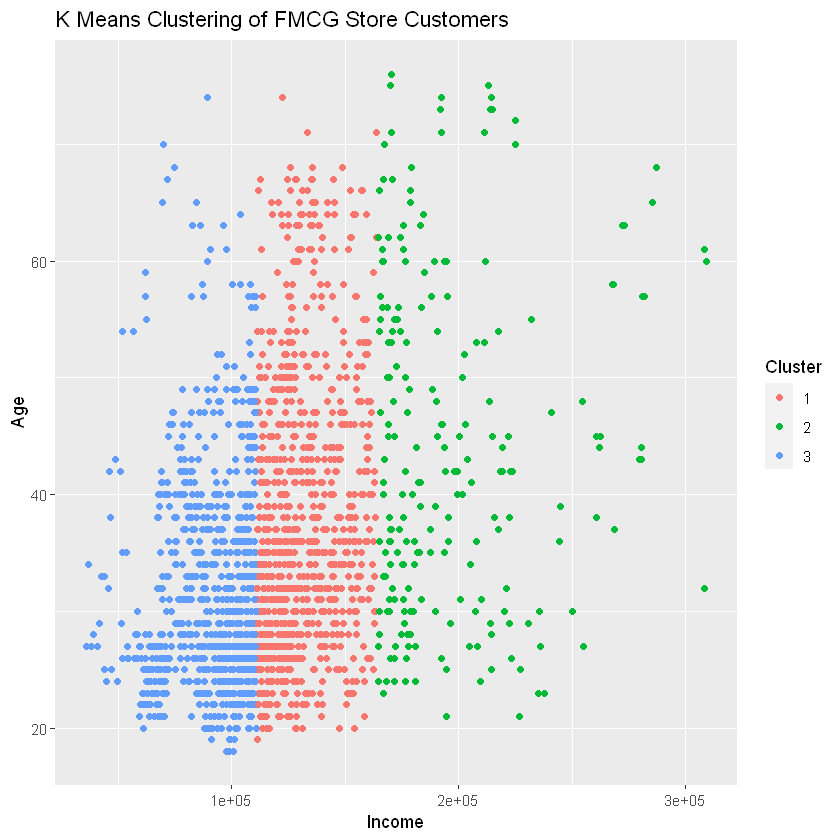

In [87]:
library(ggplot2)
ggplot(customData, aes(x = Income, y = Age, color = factor(k$cluster))) +
  geom_point() +
  labs(title = "K Means Clustering of FMCG Store Customers",
       x = "Income",
       y = "Age",
       color = "Cluster")

In [88]:
aggregate(customData, by = list(k$cluster), mean)

Group.1,Sex,Marital.status,Age,Education,Income,Occupation,Settlement.size
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.3859844,0.4471635,37.78532,1.072303,131420.04,0.9911012,0.9499444
2,0.2933333,0.4577778,43.87556,1.346667,197576.12,1.5777778,1.3644444
3,0.5719178,0.5570776,31.93721,0.923516,90533.78,0.4280822,0.3618721


#### K Means Clustering and Analysis (Three Cluster Solution)

In [89]:
k <- kmeans(customData, 4)

In [90]:
table(k$cluster)


  1   2   3   4 
954 486 105 455 

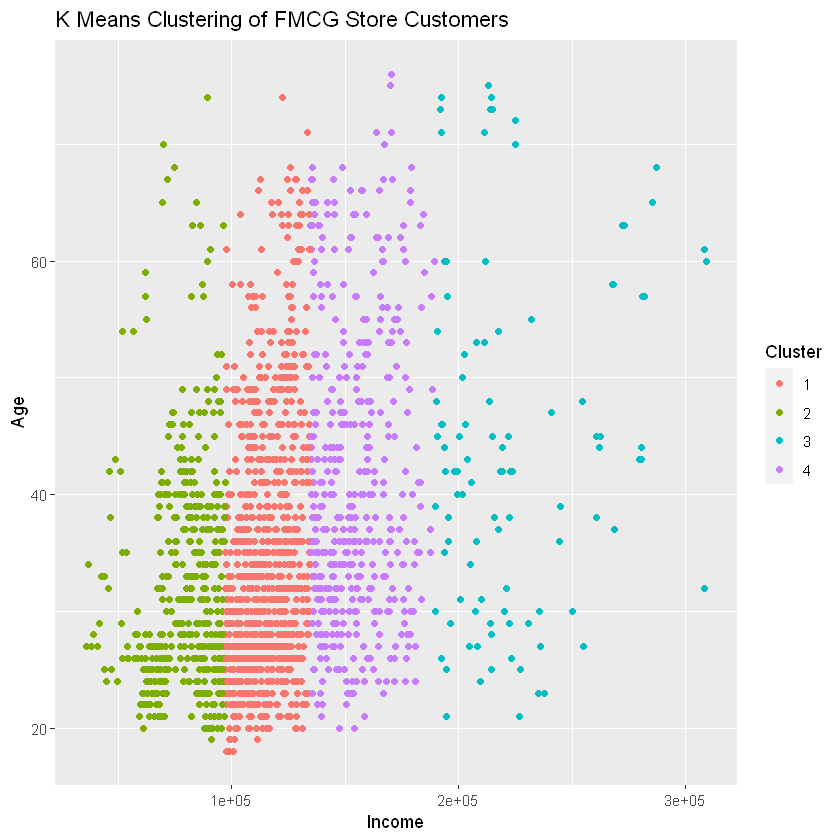

In [91]:
library(ggplot2)
ggplot(customData, aes(x = Income, y = Age, color = factor(k$cluster))) +
  geom_point() +
  labs(title = "K Means Clustering of FMCG Store Customers",
       x = "Income",
       y = "Age",
       color = "Cluster")

In [92]:
aggregate(customData, by = list(k$cluster), mean)

Group.1,Sex,Marital.status,Age,Education,Income,Occupation,Settlement.size
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.5052411,0.5272537,34.43291,1.0031447,114888.38,0.8291405,0.7148847
2,0.5432099,0.5144033,32.22016,0.8950617,79196.03,0.1563786,0.1646091
3,0.2857143,0.4000000,44.59048,1.3428571,225124.87,1.7714286,1.4666667
4,0.3032967,0.4351648,40.94066,1.1934066,154237.23,1.2483516,1.2351648


In [93]:
bcss <- k$betweenss

In [94]:
bcss

[1] 2.526003e+12

In observing the results above I might prefer the cluster solution as there is enough distinctiveness between the individual clusters to really begin to pick apart each cluster and their individual properties. 

In observing the aggregated means of the numerical explanatory variables Age and Income in the four cluster solution, there are some interesting leads to explore further. There are almost distinct age ranges of 5 years between the ages of 30 and 45 as income levels also generally rise as age rises. This makes sense, as it can be assumed that members of the population will tend to earn more as they get older.

While Cluster 3 is the cluster with the highest earners it is also the cluster with the most males which might be assumed to be caused by the infamous gender pay gap. However, it also includes most members of the sample that live in large cities, which might mean that they earn more there as well. It also includes members of the sample that have a higher level of education and are either managers or self-employed or highly skilled. 